OpenGAN: Open-Set Recognition via Open Data Generation
================
**Supplemental Material for ICCV2021 Submission**


In this notebook, we demonstrate how we train the GAN-fea model on the TinyImageNet train-set, providing the closed-set images.

import packages
------------------

Some packages are installed automatically through Anaconda. PyTorch should be also installed.

In [1]:
from __future__ import print_function, division
import os, random, time, copy
from skimage import io, transform
import numpy as np
import pandas as pd
import os.path as path
import scipy.io as sio
from scipy import misc
from scipy import ndimage, signal
import scipy
import pickle
import sys
import math
import matplotlib.pyplot as plt
import PIL.Image
from io import BytesIO


import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler 
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
import torchvision.utils as vutils
from torchvision import transforms as T
import torchinfo

from utils.eval_funcs import *
from utils.dataset_tinyimagenet import *

import warnings # ignore warnings
warnings.filterwarnings("ignore")
print(sys.version)
print(torch.__version__)


manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

/home/zullich/giovanni/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


3.10.4 (main, Mar 31 2022, 08:41:55) [GCC 7.5.0]
1.11.0
Random Seed:  999


Setup config parameters
 -----------------
 
 There are several things to setup, like which GPU to use, where to read images and save files, etc. Please read and understand this. By default, you should be able to run this script smoothly by changing nothing.

In [3]:
# set the random seed
torch.manual_seed(0)

################## set attributes for this project/experiment ##################
# config result folder
exp_dir = './exp' # experiment directory, used for reading the init model

modelFlag = 'Res18sc'

project_name = 'step002_GANfea_redux_val_p3' + modelFlag   # we save all the checkpoints in this directory

# set device, which gpu to use.
device ='cpu'
if torch.cuda.is_available(): 
    device='cuda:0'


total_epoch_num = 600 # total number of epoch in training
batch_size = 128    

newsize = (64, 64)


path_to_feats = './feats' # the path to cached off-the-shelf features
pklName = path.join(path_to_feats, modelFlag.lower()+'.pkl')



# For GAN-fea, we set the hyper-parameters as below.

# Number of channels in the training images. For color images this is 3
nc = 512

# Size of z latent vector (i.e. size of generator input)
nz = 100
# nz = 16
spatial_dim_noise = 8

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# # TinyImageNet has 200 classes.
# nClassTotal = 200
# nClassCloseset = nClassTotal

#project_name += '_K{}run{}'.format(nClassCloseset, runIdx)
if not os.path.exists(exp_dir): os.makedirs(exp_dir)


num_epochs = total_epoch_num
torch.cuda.device_count()
torch.cuda.empty_cache()

save_dir = os.path.join(exp_dir, project_name)
print(save_dir)    
if not os.path.exists(save_dir): os.makedirs(save_dir)

log_filename = os.path.join(save_dir, 'train.log')

./exp/step002_GANfea_redux_val_p3Res18sc


Define model architecture
---------

Here is the definition of the model architectures for generator and discriminator. Both are multi-layer perceptron (MLP) networks.

In [4]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)     
        

class Generator(nn.Module):
    def __init__(self, ngpu=1, nz=100, ngf=64, nc=512):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.nz = nz
        self.ngf = ngf
        self.nc = nc
        
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            # Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
            nn.Conv2d( self.nz, self.ngf * 8, 1, 1, 0, bias=False),
            nn.BatchNorm2d(self.ngf * 8),
            nn.ReLU(True),
            # state size. (self.ngf*8) x 4 x 4
            nn.Conv2d(self.ngf * 8, self.ngf * 4, 1, 1, 0, bias=False),
            nn.BatchNorm2d(self.ngf * 4),
            nn.ReLU(True),
            # state size. (self.ngf*4) x 8 x 8
            nn.Conv2d( self.ngf * 4, self.ngf * 2, 1, 1, 0, bias=False),
            nn.BatchNorm2d(self.ngf * 2),
            nn.ReLU(True),
            # state size. (self.ngf*2) x 16 x 16
            nn.Conv2d( self.ngf * 2, self.ngf*4, 1, 1, 0, bias=False),
            nn.BatchNorm2d(self.ngf*4),
            nn.ReLU(True),
            # state size. (self.ngf) x 32 x 32
            nn.Conv2d( self.ngf*4, self.nc, 1, 1, 0, bias=True),
            #nn.Tanh()
            # state size. (self.nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

    
class Discriminator(nn.Module):
    def __init__(self, ngpu=1, nc=512, ndf=64):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.nc = nc
        self.ndf = ndf
        self.main = nn.Sequential(
            nn.Conv2d(self.nc, self.ndf*8, 1, 1, 0, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.ndf*8, self.ndf*4, 1, 1, 0, bias=False),
            nn.BatchNorm2d(self.ndf*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.ndf*4, self.ndf*2, 1, 1, 0, bias=False),
            nn.BatchNorm2d(self.ndf*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.ndf*2, self.ndf, 1, 1, 0, bias=False),
            nn.BatchNorm2d(self.ndf),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.ndf, 1, 1, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

class DiscriminatorFunnel(nn.Module):
    def __init__(self, ngpu=1, nc=512, ndf=64):
        super(DiscriminatorFunnel, self).__init__()
        self.ngpu = ngpu
        self.nc = nc
        self.ndf = ndf
        self.main = nn.Sequential(
            nn.Conv2d(self.nc, self.ndf*8, 3, 1, 0, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.ndf*8, self.ndf*4, 3, 1, 0, bias=False),
            nn.BatchNorm2d(self.ndf*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.ndf*4, self.ndf*2, 3, 1, 0, bias=False),
            nn.BatchNorm2d(self.ndf*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.ndf*2, self.ndf, 2, 1, 0, bias=False),
            nn.BatchNorm2d(self.ndf),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.ndf, 1, 1, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

## initialize the networks

In [5]:
netG = Generator(ngpu=ngpu, nz=nz, ngf=ngf, nc=nc).to(device)
netD = DiscriminatorFunnel(ngpu=ngpu, nc=nc, ndf=ndf).to(device)
    # Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)
netG.apply(weights_init)


cuda:0


## Sanity Check

In [6]:
noise = torch.randn(batch_size, nz, spatial_dim_noise, spatial_dim_noise, device=device)
# Generate fake image batch with G
fake = netG(noise)
predLabel = netD(fake)

print(noise.shape, fake.shape, predLabel.shape)

torch.Size([128, 100, 8, 8]) torch.Size([128, 512, 8, 8]) torch.Size([128, 1, 1, 1])


## Dataset setup

Load the pretrained network

In [7]:
backbone_weights = torch.load("resnet18_minusvalid_no_aug.pt_resnet18_0.pt")
backbone_weights.keys()
backbone_weights["fc.weight"].shape

backbone = torchvision.models.resnet18(num_classes=backbone_weights["fc.weight"].shape[0])
backbone.load_state_dict(backbone_weights)
backbone = backbone.cuda()


Add a forward hook for storing intermediate representations

In [9]:
features = []
def get_features(module, input_, output):
    features.append(output.cpu().detach())

handle = backbone.layer4.register_forward_hook(get_features)

Load the dataset

In [10]:
import sys
sys.path.append("../CV_thesis_GiovanniPinna/")
from data import get_dataloaders

transform = T.Compose([
        T.Resize((256, 256)),
        # data.To01(),
        T.ToTensor(),
        T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ])

batch_size_eval = 64

root_data = "../CV_thesis_GiovanniPinna/ImageSet"

trainloader, testloader = get_dataloaders(root_data + "/train_final", root_data + "/valid_final", transform, transform, batch_size_eval, batch_size_eval)

get hidden features (scroll down to get pretrained ones)

In [12]:
for i, (data, _) in enumerate(trainloader):
    print(f"Done {i+1}/{len(trainloader)}")
    _ = backbone(data.cuda())

Done 1/43
Done 2/43
Done 3/43
Done 4/43
Done 5/43
Done 6/43
Done 7/43
Done 8/43
Done 9/43
Done 10/43
Done 11/43
Done 12/43
Done 13/43
Done 14/43
Done 15/43
Done 16/43
Done 17/43
Done 18/43
Done 19/43
Done 20/43
Done 21/43
Done 22/43
Done 23/43
Done 24/43
Done 25/43
Done 26/43
Done 27/43
Done 28/43
Done 29/43
Done 30/43
Done 31/43
Done 32/43
Done 33/43
Done 34/43
Done 35/43
Done 36/43
Done 37/43
Done 38/43
Done 39/43
Done 40/43
Done 41/43
Done 42/43
Done 43/43


In [178]:
# save
features = torch.cat(features, dim=0)
torch.save(features, "punzoni_resnet18_features_final_minusval.pt")

TypeError: cat() received an invalid combination of arguments - got (Tensor, dim=int), but expected one of:
 * (tuple of Tensors tensors, int dim, *, Tensor out)
 * (tuple of Tensors tensors, name dim, *, Tensor out)


### Load the preevaluated features

In [279]:
features = torch.load("punzoni_resnet18_features_final_minusval.pt")

## a helper function to read cached off-the-shelf features per closed images

In [13]:
class FeatDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.current_set_len = data.shape[0]        
        
    def __len__(self):        
        return self.current_set_len
    
    def __getitem__(self, idx):
        curdata = self.data[idx]        
        return curdata

In [14]:
trainset_closeset = FeatDataset(data=features)
dataloader = DataLoader(trainset_closeset, batch_size=batch_size, shuffle=True, num_workers=1)

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
data_sampler = iter(dataloader)
feaList = next(data_sampler)
print(feaList.shape)

torch.Size([128, 512, 8, 8])


setup training
-----------

In [308]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

lr = 0.0001

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr/5, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [309]:
# Training Loop

# Lists to keep track of progress
# img_list = []
G_losses = []
D_losses = []
iters = 0

label_smoothing_factor = 0.15

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # labels smoothing
        label -= (torch.rand(b_size, device=device) * label_smoothing_factor * (1 if real_label==1 else -1))
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, spatial_dim_noise, spatial_dim_noise, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # labels smoothing
        label += (torch.rand(b_size, device=device) * label_smoothing_factor * (1 if fake_label==0 else -1))
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()
        

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 200 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        # if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
        #     with torch.no_grad():
        #         fake = netG(fixed_noise).detach().cpu()
        #     img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        # iters += 1
        
        
    cur_model_wts = copy.deepcopy(netG.state_dict())
    path_to_save_paramOnly = os.path.join(save_dir, 'epoch-{}.GNet'.format(epoch+1))
    torch.save(cur_model_wts, path_to_save_paramOnly)
    
    cur_model_wts = copy.deepcopy(netD.state_dict())
    path_to_save_paramOnly = os.path.join(save_dir, 'epoch-{}.DNet'.format(epoch+1))
    torch.save(cur_model_wts, path_to_save_paramOnly)

Starting Training Loop...
[0/300][0/22]	Loss_D: 0.5453	Loss_G: 2.4832	D(x): 0.9081	D(G(z)): 0.0878 / 0.0859
[1/300][0/22]	Loss_D: 0.5306	Loss_G: 2.4886	D(x): 0.9185	D(G(z)): 0.0877 / 0.0855
[2/300][0/22]	Loss_D: 0.5284	Loss_G: 2.4420	D(x): 0.9104	D(G(z)): 0.0919 / 0.0900
[3/300][0/22]	Loss_D: 0.5395	Loss_G: 2.4700	D(x): 0.9131	D(G(z)): 0.0893 / 0.0876
[4/300][0/22]	Loss_D: 0.5585	Loss_G: 2.4886	D(x): 0.9007	D(G(z)): 0.0877 / 0.0866
[5/300][0/22]	Loss_D: 0.5553	Loss_G: 2.4806	D(x): 0.9021	D(G(z)): 0.0882 / 0.0865


KeyboardInterrupt: 

## drawing the error curves

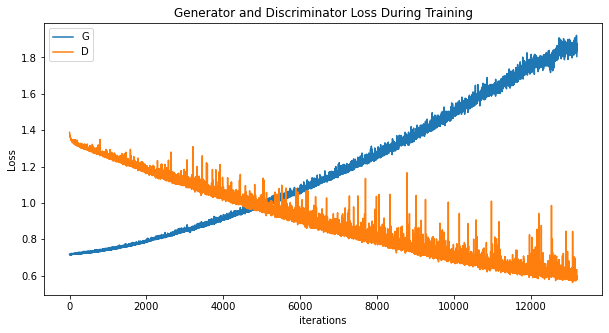

In [294]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig('learningCurves_{}.png'.format(modelFlag), bbox_inches='tight',transparent=True)
# plt.show()

## Testing

In [11]:
netD.load_state_dict(torch.load("exp/step002_GANfea_v1_Res18sc/epoch-300.DNet"))

<All keys matched successfully>

In [17]:
features = []

backbone.eval()
for i, (data, _) in enumerate(testloader):
    print(f"Doing {i+1}/{len(testloader)}")
    _ = backbone(data.cuda())

Doing 1/5
Doing 2/5
Doing 3/5
Doing 4/5
Doing 5/5


In [18]:
features = torch.cat(features, dim=0)

In [27]:
torch.save(features, "punzoni_res18_features_TEST.pt")

In [13]:
features = torch.load("punzoni_res18_features_TEST.pt")

In [19]:
testset_closeset = FeatDataset(data=features)
testloader = DataLoader(testset_closeset, batch_size=batch_size, shuffle=True, num_workers=1)

In [20]:
len(testset_closeset)

626

Correctly identified items: 1.0
Correctly identified fakes: 0.983


Text(0.5, 1.0, 'ROC score 0.99998')

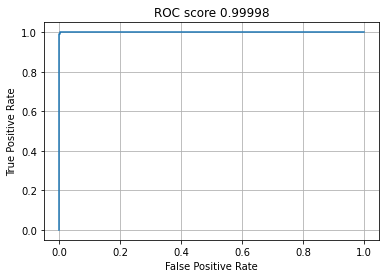

In [21]:
x = next(iter(testloader)).cuda()
(netD(x).view(-1) >= .5).sum().item() / x.size(0)

correct = 0
netD.train()

outputs_close = []
with torch.no_grad():
    for test_data in testloader:
        output = netD(test_data.cuda()).view(-1)
        outputs_close += [output.cpu()]
        correct += (output >= .5).sum().item()

outputs_close = torch.cat(outputs_close).numpy()

print("Correctly identified items:", correct/len(testloader.dataset))

correct_fake = 0
outputs_open = []
with torch.no_grad():
    for ite in range(10):
        #noise = torch.randn(100, 512, 8, 8, device=device)
        features = []
        noiseimg = torch.randn(100, 3, 256, 256, device=device)
        _ = backbone(noiseimg)
        feats = features[0].cuda()
        assert feats.shape == (100, 512, 8, 8), f"Features shape is {feats.shape}, expected (100, 512, 8, 8)"
        output = netD(feats).view(-1)
        outputs_open.append(output.cpu())
        correct_fake += (output < .5).sum().item()
outputs_open = torch.cat(outputs_open).numpy()

print("Correctly identified fakes:", correct_fake/1000)

roc_score, roc_to_plot = evaluate_openset(outputs_open, outputs_close)
plt.plot(roc_to_plot['fp'], roc_to_plot['tp'])
plt.grid('on')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC score {:.5f}'.format(roc_score))

test con punzoni **grandi**

In [223]:
from PIL import Image

transform = T.Compose([
        T.Resize((256, 256)),
        T.ToTensor(),
        T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ])

batch_size_eval = 64

root_data = "../CV_thesis_GiovanniPinna/ImageSet/train/Grandi/"
root_testdata = "../CV_thesis_GiovanniPinna/ImageSet/test/Grandi/"

imgs = [transform(Image.open(os.path.join(root_data,i))) for i in os.listdir(root_data)]
imgs += [transform(Image.open(os.path.join(root_testdata,i))) for i in os.listdir(root_testdata)]
imgs = torch.stack(imgs)

In [224]:
features = []

backbone.eval()
_ = backbone(imgs.cuda())

In [225]:
netD.train()
output_composti = netD(features[0].cuda()).view(-1).detach().cpu().numpy()

In [226]:
output_composti

array([0.03614169, 0.13188133, 0.22271664, 0.40477863, 0.36695084,
       0.25565153, 0.45886257, 0.06041168, 0.02849863, 0.03334023,
       0.19013801, 0.05493907, 0.11447396, 0.13238226, 0.10767952],
      dtype=float32)

test con **no punzoni**

In [227]:
transform = T.Compose([
        T.Resize((256, 256)),
        T.ToTensor(),
        T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ])

batch_size_eval = 64

root_data = "../CV_thesis_GiovanniPinna/ImageSet/No_punzoni/No_punzoni/"

imgs = [transform(Image.open(os.path.join(root_data,i))) for i in os.listdir(root_data)]
imgs = torch.stack(imgs)

features = []

backbone.eval()
_ = backbone(imgs.cuda())

netD.train()
outputs_nopunz = netD(features[0].cuda()).view(-1)
outputs_nopunz = outputs_nopunz.detach().cpu().numpy()


In [228]:
outputs_nopunz

array([0.27878183, 0.42130584, 0.02073064, 0.1769452 , 0.02638935,
       0.15796275, 0.15667205, 0.19017813, 0.10892434, 0.52115977,
       0.07141458, 0.45866367, 0.00710254, 0.38995004, 0.04471656],
      dtype=float32)

Text(0.5, 1.0, 'ROC score 0.99437')

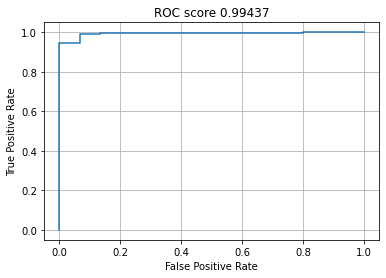

In [162]:
roc_score, roc_to_plot = evaluate_openset(outputs_nopunz, outputs_close)
plt.plot(roc_to_plot['fp'], roc_to_plot['tp'])
plt.grid('on')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC score {:.5f}'.format(roc_score))

test con **altri punzoni extra**

In [1]:
transform = T.Compose([
        T.Resize((256, 256)),
        T.ToTensor(),
        T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ])

batch_size_eval = 64

root_data = "../CV_thesis_GiovanniPinna/ImageSet/extra_train/"

extra_ds = torchvision.datasets.ImageFolder(root=root_data, transform=transform)
extra_dl = torch.utils.data.DataLoader(extra_ds, batch_size=len(extra_ds), shuffle=False, num_workers=1)

features = []

backbone.eval()
_ = backbone(next(iter(extra_dl))[0].cuda())

netD.train()
outputs_extra = netD(features[0].cuda()).view(-1)
outputs_extra = outputs_extra.detach().cpu().numpy()


NameError: name 'T' is not defined

In [312]:
torch.save(torch.from_numpy(outputs_extra), "outputs_ood_train.pt")
torch.save(torch.from_numpy(outputs_close), "outputs_valid.pt")
torch.save(torch.from_numpy(outputs_nopunz), "outputs_crops.pt")
torch.save(torch.from_numpy(outputs_open), "outputs_random.pt")

In [230]:
outputs_extra

array([0.28935257, 0.375004  , 0.14068295, 0.41131547, 0.34069493,
       0.19066136, 0.5747589 , 0.74599713, 0.55927753, 0.3160395 ,
       0.11001829, 0.23722832, 0.33327243, 0.15292104, 0.26261202,
       0.11334129, 0.48497576, 0.34152555, 0.38191482], dtype=float32)

In [231]:
outputs_close

array([0.88747036, 0.9004076 , 0.8224729 , 0.8692346 , 0.8922849 ,
       0.90174043, 0.90096986, 0.8950197 , 0.895969  , 0.90580523,
       0.89768773, 0.9415842 , 0.89414734, 0.89606667, 0.9048079 ,
       0.88658625, 0.89229983, 0.8857224 , 0.8864584 , 0.89086044,
       0.8820801 , 0.89312416, 0.89979017, 0.8940206 , 0.89560527,
       0.8943877 , 0.8958931 , 0.89298934, 0.87646574, 0.89878464,
       0.898369  , 0.907703  , 0.9287664 , 0.8948314 , 0.897249  ,
       0.89277667, 0.88637996, 0.89627165, 0.91777635, 0.94600356,
       0.8972681 , 0.8925855 , 0.9216061 , 0.89862293, 0.89566827,
       0.84723383, 0.7826829 , 0.89397746, 0.8982131 , 0.89285237,
       0.8975709 , 0.89852   , 0.90325814, 0.8784707 , 0.90291476,
       0.9082935 , 0.9316184 , 0.8848186 , 0.89115256, 0.89234483,
       0.894168  , 0.90512645, 0.8905836 , 0.90028644, 0.88301677,
       0.89084005, 0.89166784, 0.9001026 , 0.89439857, 0.8897256 ,
       0.89027566, 0.89235014, 0.94366115, 0.8909313 , 0.89579

Text(0.5, 1.0, 'ROC score 0.99751')

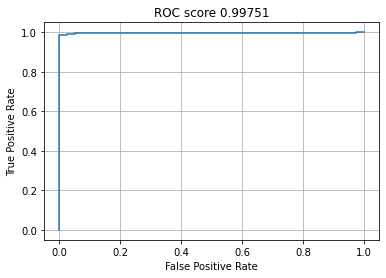

In [166]:
roc_score, roc_to_plot = evaluate_openset(outputs_extra, outputs_close)
plt.plot(roc_to_plot['fp'], roc_to_plot['tp'])
plt.grid('on')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC score {:.5f}'.format(roc_score))

In [69]:
import sklearn

def mean_ap(outputs1, outputs2):
    y_true = [1] * len(outputs1) + [0] * len(outputs2)
    y_score = np.concatenate([outputs1, outputs2])
    return sklearn.metrics.average_precision_score(y_true, y_score)

mean_ap(outputs_close, outputs_extra)

0.9984245586353054

In [70]:
mean_ap(outputs_close, outputs_nopunz)

0.9999882176370101

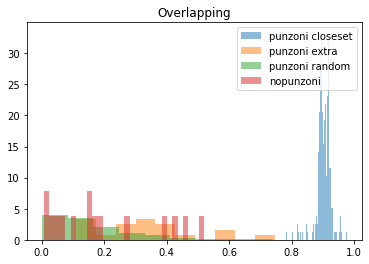

In [236]:
plt.hist(outputs_close, label="punzoni closeset", density=True, bins=100, alpha=0.5)
plt.hist(outputs_extra, label="punzoni extra", density=True, alpha=0.5)
plt.hist(outputs_open, label="punzoni random", density=True, alpha=0.5)
plt.hist(outputs_nopunz, label="nopunzoni", density=True, bins=30, alpha=0.5)
plt.legend(loc='upper right')
plt.title('Overlapping')
plt.show()

In [18]:
outputs_close = torch.load("outputs_valid.pt")
outputs_extra = torch.load("outputs_ood_train.pt")
outputs_open = torch.load("outputs_random.pt")

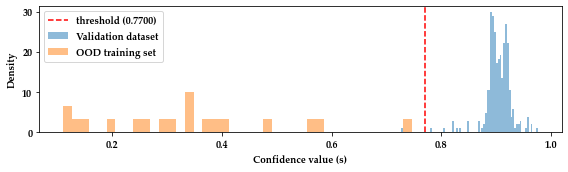

In [17]:
from matplotlib import pyplot as plt, font_manager as fm, rcParams
palatino_path = os.path.expanduser("~/.fonts/Palatino Linotype.ttf")
fm.fontManager.addfont(palatino_path)
rcParams['font.family'] = 'Palatino Linotype'

fig = plt.figure(figsize=(8,2.5))
plt.axvline(0.77, color="r", linestyle="--", label=f"threshold ({0.77:.4f})")
plt.hist(outputs_close.numpy(), label="Validation dataset", density=True, bins=75, alpha=0.5)
plt.hist(outputs_extra.numpy(), label="OOD training set", density=True, bins=40, alpha=0.5)
plt.ylabel("Density")
plt.xlabel("Confidence value (s)")

plt.legend(loc='upper left')
plt.tight_layout()

plt.savefig("validation_vs_ood_opengan.pdf")

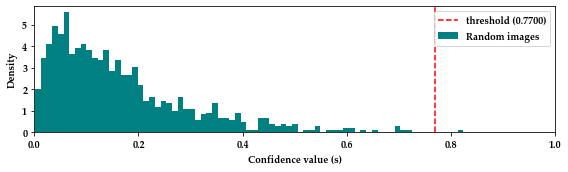

In [34]:
from matplotlib import pyplot as plt, font_manager as fm, rcParams
palatino_path = os.path.expanduser("~/.fonts/Palatino Linotype.ttf")
fm.fontManager.addfont(palatino_path)
rcParams['font.family'] = 'Palatino Linotype'

fig = plt.figure(figsize=(8,2.5))
plt.axvline(0.77, color="r", linestyle="--", label=f"threshold ({0.77:.4f})")
plt.hist(outputs_open.numpy(), label="Random images", density=True, bins=75, color="teal")
plt.ylabel("Density")
plt.xlabel("Confidence value (s)")
plt.xlim((0,1))

plt.legend(loc='upper right')
plt.tight_layout()

plt.savefig("opengan_randimgs.pdf")

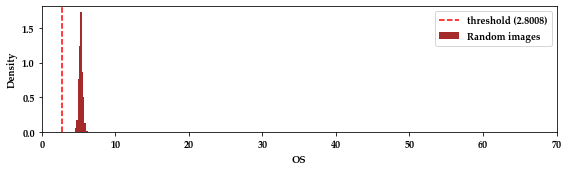

In [33]:
outputs_ii = torch.load("/media/zullich/LabControlli1/punches_recognition/models/ii_delta_0.5.pth_rand.pth")

from matplotlib import pyplot as plt, font_manager as fm, rcParams
palatino_path = os.path.expanduser("~/.fonts/Palatino Linotype.ttf")
fm.fontManager.addfont(palatino_path)
rcParams['font.family'] = 'Palatino Linotype'

fig = plt.figure(figsize=(8,2.5))
plt.axvline(2.8008, color="r", linestyle="--", label=f"threshold ({2.8008:.4f})")
plt.hist(outputs_ii.numpy(), label="Random images", density=True, bins=10, color="brown")
plt.ylabel("Density")
plt.xlabel("OS")
plt.xlim((0, 70))

plt.legend(loc='upper right')
plt.tight_layout()

plt.savefig("ii_randimgs.pdf")

In [26]:
outputs_ii.norm(), 

tensor(118.7478)

# QUANTITATIVE ASSESSMENT

In [247]:
torch.linspace(0+.01,1-.01,int(1/0.01)-1)

tensor([0.0100, 0.0200, 0.0300, 0.0400, 0.0500, 0.0600, 0.0700, 0.0800, 0.0900,
        0.1000, 0.1100, 0.1200, 0.1300, 0.1400, 0.1500, 0.1600, 0.1700, 0.1800,
        0.1900, 0.2000, 0.2100, 0.2200, 0.2300, 0.2400, 0.2500, 0.2600, 0.2700,
        0.2800, 0.2900, 0.3000, 0.3100, 0.3200, 0.3300, 0.3400, 0.3500, 0.3600,
        0.3700, 0.3800, 0.3900, 0.4000, 0.4100, 0.4200, 0.4300, 0.4400, 0.4500,
        0.4600, 0.4700, 0.4800, 0.4900, 0.5000, 0.5100, 0.5200, 0.5300, 0.5400,
        0.5500, 0.5600, 0.5700, 0.5800, 0.5900, 0.6000, 0.6100, 0.6200, 0.6300,
        0.6400, 0.6500, 0.6600, 0.6700, 0.6800, 0.6900, 0.7000, 0.7100, 0.7200,
        0.7300, 0.7400, 0.7500, 0.7600, 0.7700, 0.7800, 0.7900, 0.8000, 0.8100,
        0.8200, 0.8300, 0.8400, 0.8500, 0.8600, 0.8700, 0.8800, 0.8900, 0.9000,
        0.9100, 0.9200, 0.9300, 0.9400, 0.9500, 0.9600, 0.9700, 0.9800, 0.9900])

In [248]:
from typing import Collection, Union, List

def eval_on_threshold(outlier_scores:torch.Tensor, threshold:float, comparison_fn=torch.gt) -> float:
    '''
    Thresholds the outlier scores on the given threshold with respect to the specified comparison operator.
    
    Parameters
    ----------
    outlier_scores: a torch.Tensor containing the outlier scores for a data set (e.g., train, validation...)
    threshold: a float specifying the threshold to use
    comparison_fn: a torch.Tensor comparison function (e.g., torch.gt, torch.le). Defaults to torch.gt. It operates the comparison between the outlier scores and the threshold. E.g., if comparison_fn is torch.gt, then it evals on outlier scores being greater than the threshold.
    '''
    return (comparison_fn(outlier_scores, threshold)).sum().item()

def eval_multiple_outlier_scores_series_on_thresholds(outlier_scores:Collection[torch.Tensor], comparison_fns:Collection, thresholds:Union[float,Collection[float]], series_names:Collection[str]=None) -> List[float]:
    '''
    Evaluates multiple outlier scores on multiple thresholds with respect to the specified comparison operators.
    
    Parameters
    ----------
    outlier_scores: a collection of torch.Tensor containing the outlier scores for a data set (e.g., train, validation...)
    comparison_fns: a collection of torch.Tensor comparison functions (e.g., torch.gt, torch.le). It operates the comparison between the outlier scores and the threshold. Must have same size as outlier_scores.
    thresholds: a collection of floats specifying the thresholds to use. Can be a float or a collection of floats.
    series_names: a collection of strings specifying the names of the series. Defaults to None. If specified, must have same size as outlier_scores.
    '''
    assert len(outlier_scores) == len(comparison_fns), f"Expected len(outlier_scores) ({len(outlier_scores)}) to be equal to len(comparison_fns) ({len(comparison_fns)})"
    if series_names is not None:
        assert len(outlier_scores) == len(series_names), f"Expected len(outlier_scores) ({len(outlier_scores)}) to be equal to len(series_names) ({len(series_names)})"
    else:
        series_names = range(len(outlier_scores))
    
    if isinstance(thresholds, float):
        thresholds = [thresholds]

    results = {"threshold": []}
    for name in series_names:
        results[name + "_N"] = []
        results[name + "_N_corr"] = []
        results[name + "_pct"] = []
    for th in thresholds:
        results["threshold"].append(th)
        for scores, fn, name in zip(outlier_scores, comparison_fns, series_names):
            results[name + "_N"].append(len(scores))
            N_corr = eval_on_threshold(scores, th, fn)
            results[name + "_N_corr"].append(N_corr)
            results[name + "_pct"].append(N_corr / len(scores))
    return results

In [251]:
results = eval_multiple_outlier_scores_series_on_thresholds([torch.from_numpy(outputs_close), torch.from_numpy(outputs_nopunz), torch.from_numpy(outputs_extra), torch.from_numpy(outputs_open)], [torch.gt, torch.lt, torch.lt, torch.lt], torch.linspace(0+.01,1-.01,int(1/0.01)-1), ("validation", "crops", "ood", "random"))
results = pd.DataFrame(results)
    

In [256]:
results

,threshold,validation_N,validation_N_corr,validation_pct,crops_N,crops_N_corr,crops_pct,ood_N,ood_N_corr,ood_pct,random_N,random_N_corr,random_pct,W_sens_spec
0,tensor(0.0100),313,313,1.000000,15,1,0.066667,19,0,0.0,1000,17,0.017,0.000000
1,tensor(0.0200),313,313,1.000000,15,1,0.066667,19,0,0.0,1000,42,0.042,0.000000
2,tensor(0.0300),313,313,1.000000,15,3,0.200000,19,0,0.0,1000,92,0.092,0.000000
3,tensor(0.0400),313,313,1.000000,15,3,0.200000,19,0,0.0,1000,134,0.134,0.000000
4,tensor(0.0500),313,313,1.000000,15,4,0.266667,19,0,0.0,1000,181,0.181,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,tensor(0.9500),313,8,0.025559,15,15,1.000000,19,19,1.0,1000,1000,1.000,0.115942
95,tensor(0.9600),313,3,0.009585,15,15,1.000000,19,19,1.0,1000,1000,1.000,0.046154
96,tensor(0.9700),313,1,0.003195,15,15,1.000000,19,19,1.0,1000,1000,1.000,0.015773
97,tensor(0.9800),313,0,0.000000,15,15,1.000000,19,19,1.0,1000,1000,1.000,0.000000


In [257]:
results["W_sens_spec"] = 5 * results.validation_pct * results.ood_pct / (4*results.validation_pct + results.ood_pct)
results["all_pct"] = (results.crops_N_corr + results.ood_N_corr + results.random_N_corr) / (results.crops_N + results.ood_N + results.random_N)
results["WA_sens_spec"] = 5 * results.validation_pct * results.all_pct / (4*results.validation_pct + results.all_pct)
results.nlargest(10, "W_sens_spec")

,threshold,validation_N,validation_N_corr,validation_pct,crops_N,crops_N_corr,crops_pct,ood_N,ood_N_corr,ood_pct,random_N,random_N_corr,random_pct,W_sens_spec,all_pct,WA_sens_spec
74,tensor(0.7500),313,312,0.996805,15,15,1.0,19,19,1.0,1000,999,0.999,0.999359,0.999033,0.998587
75,tensor(0.7600),313,312,0.996805,15,15,1.0,19,19,1.0,1000,999,0.999,0.999359,0.999033,0.998587
76,tensor(0.7700),313,312,0.996805,15,15,1.0,19,19,1.0,1000,999,0.999,0.999359,0.999033,0.998587
77,tensor(0.7800),313,312,0.996805,15,15,1.0,19,19,1.0,1000,999,0.999,0.999359,0.999033,0.998587
78,tensor(0.7900),313,311,0.993610,15,15,1.0,19,19,1.0,1000,999,0.999,0.998715,0.999033,0.997944
79,tensor(0.8000),313,311,0.993610,15,15,1.0,19,19,1.0,1000,999,0.999,0.998715,0.999033,0.997944
80,tensor(0.8100),313,310,0.990415,15,15,1.0,19,19,1.0,1000,999,0.999,0.998068,0.999033,0.997297
81,tensor(0.8200),313,310,0.990415,15,15,1.0,19,19,1.0,1000,999,0.999,0.998068,0.999033,0.997297
82,tensor(0.8300),313,306,0.977636,15,15,1.0,19,19,1.0,1000,1000,1.000,0.995446,1.000000,0.995446
83,tensor(0.8400),313,305,0.974441,15,15,1.0,19,19,1.0,1000,1000,1.000,0.994781,1.000000,0.994781


In [270]:
results.insert(0, "Z", f"{nz}*{spatial_dim_noise}*{spatial_dim_noise}")
results.insert(0, "name", project_name)

In [271]:
os.makedirs("results", exist_ok=True)
filename = "results/results.csv"
header = (not os.path.isfile(filename)) or (os.stat().st_size == 0)
results.nlargest(1, "W_sens_spec").to_csv(filename, index=False, header=header, mode="a")

# TEST DATA

In [26]:
transform = T.Compose([
        T.Resize((256, 256)),
        T.ToTensor(),
        T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ])

batch_size_eval = 64

root_data = "../CV_thesis_GiovanniPinna/ImageSet/extra_test/"

extra_ds_t = torchvision.datasets.ImageFolder(root=root_data, transform=transform)
extra_dl_t = torch.utils.data.DataLoader(extra_ds_t, batch_size=len(extra_ds_t), shuffle=False, num_workers=1)

features = []

backbone.eval()
_ = backbone(next(iter(extra_dl_t))[0].cuda())

netD.train()
outputs_extra_t = netD(features[0].cuda()).view(-1)
outputs_extra_t = outputs_extra_t.detach().cpu().numpy()

In [43]:
(outputs_extra_t<=0.77).sum().item() / len(outputs_extra_t)

1.0

In [40]:
transform = T.Compose([
        T.Resize((256, 256)),
        T.ToTensor(),
        T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ])

batch_size_eval = 64

root_data = "../CV_thesis_GiovanniPinna/ImageSet/test_final/"

test_set = torchvision.datasets.ImageFolder(root=root_data, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False, num_workers=1)

features = []

backbone.eval()
for data, _ in test_loader:
    print(data.shape)
    _ = backbone(data.cuda())

# features = torch.cat(features)
features = torch.cat([f for i, f in enumerate(features) if i%2==0], dim=0)
print(features.shape)

netD.train()
outputs_test = netD(features.cuda()).view(-1)
outputs_test = outputs_test.detach().cpu().numpy()

torch.Size([128, 3, 256, 256])
torch.Size([128, 3, 256, 256])
torch.Size([128, 3, 256, 256])
torch.Size([128, 3, 256, 256])
torch.Size([128, 3, 256, 256])
torch.Size([128, 3, 256, 256])
torch.Size([2, 3, 256, 256])
torch.Size([770, 512, 8, 8])


In [42]:
(outputs_test>0.77).sum().item() / len(outputs_test)

0.9948051948051948